In [1]:
from bucket_model import BucketModel
from bucket_model_optimizer import BucketModelOptimizer
from data_preprocessor import preprocess_data

import pandas as pd

In [2]:
path_to_file = '/Users/cooper/Desktop/BucketModel/data/GSTEIGmeteo.txt'
output_destination = '/Users/cooper/Desktop/BucketModel/data/GSTEIGmeteo.csv'
catchment_area = 384.2 # km^2
training_data = preprocess_data(path_to_file=path_to_file, catchment_area=catchment_area)

# training_data = pd.read_csv(output_destination, index_col=0)
# training_data.index = pd.to_datetime(training_data.index)

training_data

,P_mix,T_max,T_min,Q
date,,,,
1986-01-01,2.5,-2.5,-11.6,0.512733
1986-01-02,0.2,2.6,-10.7,0.537470
1986-01-03,4.3,2.2,-5.3,0.532972
1986-01-04,3.4,-4.0,-12.9,0.526226
1986-01-05,3.6,1.9,-13.3,0.526226
...,...,...,...,...
2000-09-26,0.0,16.3,5.8,3.215825
2000-09-27,0.0,15.6,5.3,3.238313
2000-09-28,0.0,14.1,6.0,3.238313


In [3]:
# Initialize the BucketModel with initial parameter guesses
bucket = BucketModel(0.5, 20, 0.14, 15.15)  # k, S_max, fr, rg
bucket.set_catchment_properties(0.5/100, 1638, 2035, 0, 46.9)

# Initialize the BucketModelOptimizer with the BucketModel instance and observed data
optimizer = BucketModelOptimizer(model=bucket, training_data=training_data)

# Optionally, set additional optimization options, like optimization method, parameter bounds, etc.
optimizer.set_options(method='local', bounds={'k': (0.1, 1), 'S_max': (10, 50), 'fr': (0.1, 0.3), 'rg': (10, 20)})

In [4]:
# Run the optimization to calibrate the model parameters
optimized_parameters = optimizer.optimize()

In [5]:
optimized_parameters

{'k': 0.34910430579268387,
 'S_max': 44.31003870118485,
 'fr': 0.21813218010247828,
 'rg': 19.547247325923625}

In [6]:
bucket.update_parameters(optimized_parameters)
bucket

BucketModel(k=0.34910430579268387, S_max=44.31003870118485, fr=0.21813218010247828, rg=19.547247325923625)

In [7]:
results = bucket.run(training_data)

In [8]:
results.tail()

,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip
date,,,,,,,,,,
2000-09-26,1.166338,0.690308,4.182909,519.724463,44.310039,78.889425,3.164631,0.0,0.0,0.0
2000-09-27,1.111294,0.644617,4.035833,516.769295,44.310039,76.052849,2.955168,0.0,0.0,0.0
2000-09-28,1.072360,0.614157,3.890719,513.953769,44.310039,73.291139,2.815526,0.0,0.0,0.0
2000-09-29,0.998389,1.632474,3.749435,511.469892,44.310039,74.394718,2.483877,5.0,0.0,5.0
2000-09-30,0.907920,7.074036,3.805892,509.439850,44.310039,95.036911,2.030042,30.4,0.0,30.4


<Axes: xlabel='date'>

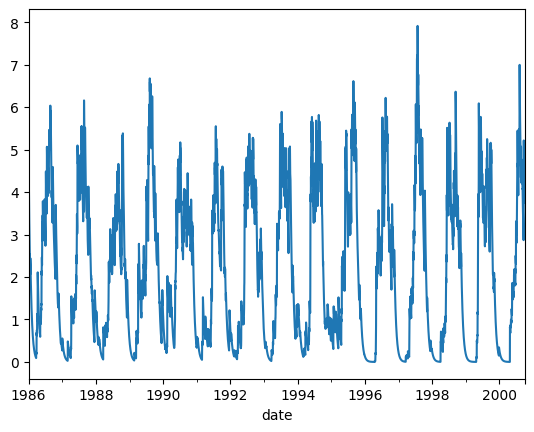

In [15]:
results.Q_gw.plot()